# PREPROCESAMIENTO DE DATOS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from scr.explore_utils import null_analysis, column_type_dataframe

In [2]:
# Configuramos que se muestren todas las columnas de nuestros dataframes
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("files\input\dataset_estudiantes.csv")

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10996\676143788.py:1: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv("files\input\dataset_estudiantes.csv")


In [4]:
df.rename(str.upper, axis='columns', inplace=True)

## 1. Gestión de duplicados

### Plan de acción
Según el EDA, no se detectaron valores duplicados en el dataset. Sin embargo, es importante verificar nuevamente antes de proceder con el modelado. Si se detectan duplicados, se evaluará si son registros idénticos que deben eliminarse o si representan casos legítimos (aunque poco probable en este contexto).

In [5]:
df.duplicated().sum()

np.int64(0)

## 2. Gestión de valores nulos
Según el EDA, se identificaron valores faltantes en tres variables que requieren imputación:

- **HORAS_SUENO** (15% faltantes, 150 registros):
  
- **HORARIO_ESTUDIO_PREFERIDO** (10% faltantes, 100 registros):
  
- **ESTILO_APRENDIZAJE** (5% faltantes, 50 registros):


###  Imputación de HORAS_SUENO (mediana)

Usamos la **mediana** porque:
- Es robusta ante outliers
- La distribución es relativamente normal (~7 horas)
- La variable tiene baja correlación con el target, por lo que no justifica métodos más costosos

In [6]:
# Imputación de HORAS_SUENO con la mediana
imputer_mediana = SimpleImputer(strategy='median')
df['HORAS_SUENO'] = imputer_mediana.fit_transform(df[['HORAS_SUENO']])

print(f"Mediana utilizada para imputación: {imputer_mediana.statistics_[0]:.2f} horas")
print(f"Valores nulos restantes en HORAS_SUENO: {df['HORAS_SUENO'].isnull().sum()}")

Mediana utilizada para imputación: 7.02 horas
Valores nulos restantes en HORAS_SUENO: 0


### Imputación de HORARIO_ESTUDIO_PREFERIDO (categoría 'Desconocido')

Usamos la categoría **'Desconocido'** porque:
- No hay un orden natural entre las categorías (Mañana, Tarde, Noche)
- Preserva la información de que realmente no conocemos el horario preferido
- El modelo puede aprender si existe un patrón en los estudiantes que no reportan su horario

In [7]:
# Imputación de HORARIO_ESTUDIO_PREFERIDO con categoría 'Desconocido'
df['HORARIO_ESTUDIO_PREFERIDO'] = df['HORARIO_ESTUDIO_PREFERIDO'].fillna('Desconocido')

print("Distribución de HORARIO_ESTUDIO_PREFERIDO después de la imputación:")
print(df['HORARIO_ESTUDIO_PREFERIDO'].value_counts())
print(f"\nValores nulos restantes: {df['HORARIO_ESTUDIO_PREFERIDO'].isnull().sum()}")

Distribución de HORARIO_ESTUDIO_PREFERIDO después de la imputación:
HORARIO_ESTUDIO_PREFERIDO
Noche          344
Tarde          337
Mañana         219
Desconocido    100
Name: count, dtype: int64

Valores nulos restantes: 0


### Imputación de ESTILO_APRENDIZAJE (moda)

Usamos la **moda** ('Visual') porque:
- Solo tiene 5% de valores nulos (bajo porcentaje)
- La moda es representativa cuando el % de nulos es bajo
- Es el método más simple y efectivo para este caso

In [8]:
# Imputación de ESTILO_APRENDIZAJE con la moda
imputer_moda = SimpleImputer(strategy='most_frequent')
df['ESTILO_APRENDIZAJE'] = imputer_moda.fit_transform(df[['ESTILO_APRENDIZAJE']]).ravel()

print(f"Moda utilizada para imputación: {imputer_moda.statistics_[0]}")
print("\nDistribución de ESTILO_APRENDIZAJE después de la imputación:")
print(df['ESTILO_APRENDIZAJE'].value_counts())
print(f"\nValores nulos restantes: {df['ESTILO_APRENDIZAJE'].isnull().sum()}")

Moda utilizada para imputación: Visual

Distribución de ESTILO_APRENDIZAJE después de la imputación:
ESTILO_APRENDIZAJE
Visual               413
Auditivo             254
Kinestésico          178
Lectura/Escritura    155
Name: count, dtype: int64

Valores nulos restantes: 0


## 3. Gestión de valores atípicos (outliers)
Según el EDA, se detectaron outliers en las siguientes variables:

- **TASA_ASISTENCIA**: 4 outliers detectados (0.4% del total) mediante método IQR
  
- **HORAS_ESTUDIO_SEMANAL**: Revisar valores extremos (rango 1-25 horas)

**Implementación**: 


### Análisis visual de outliers (Boxplots)

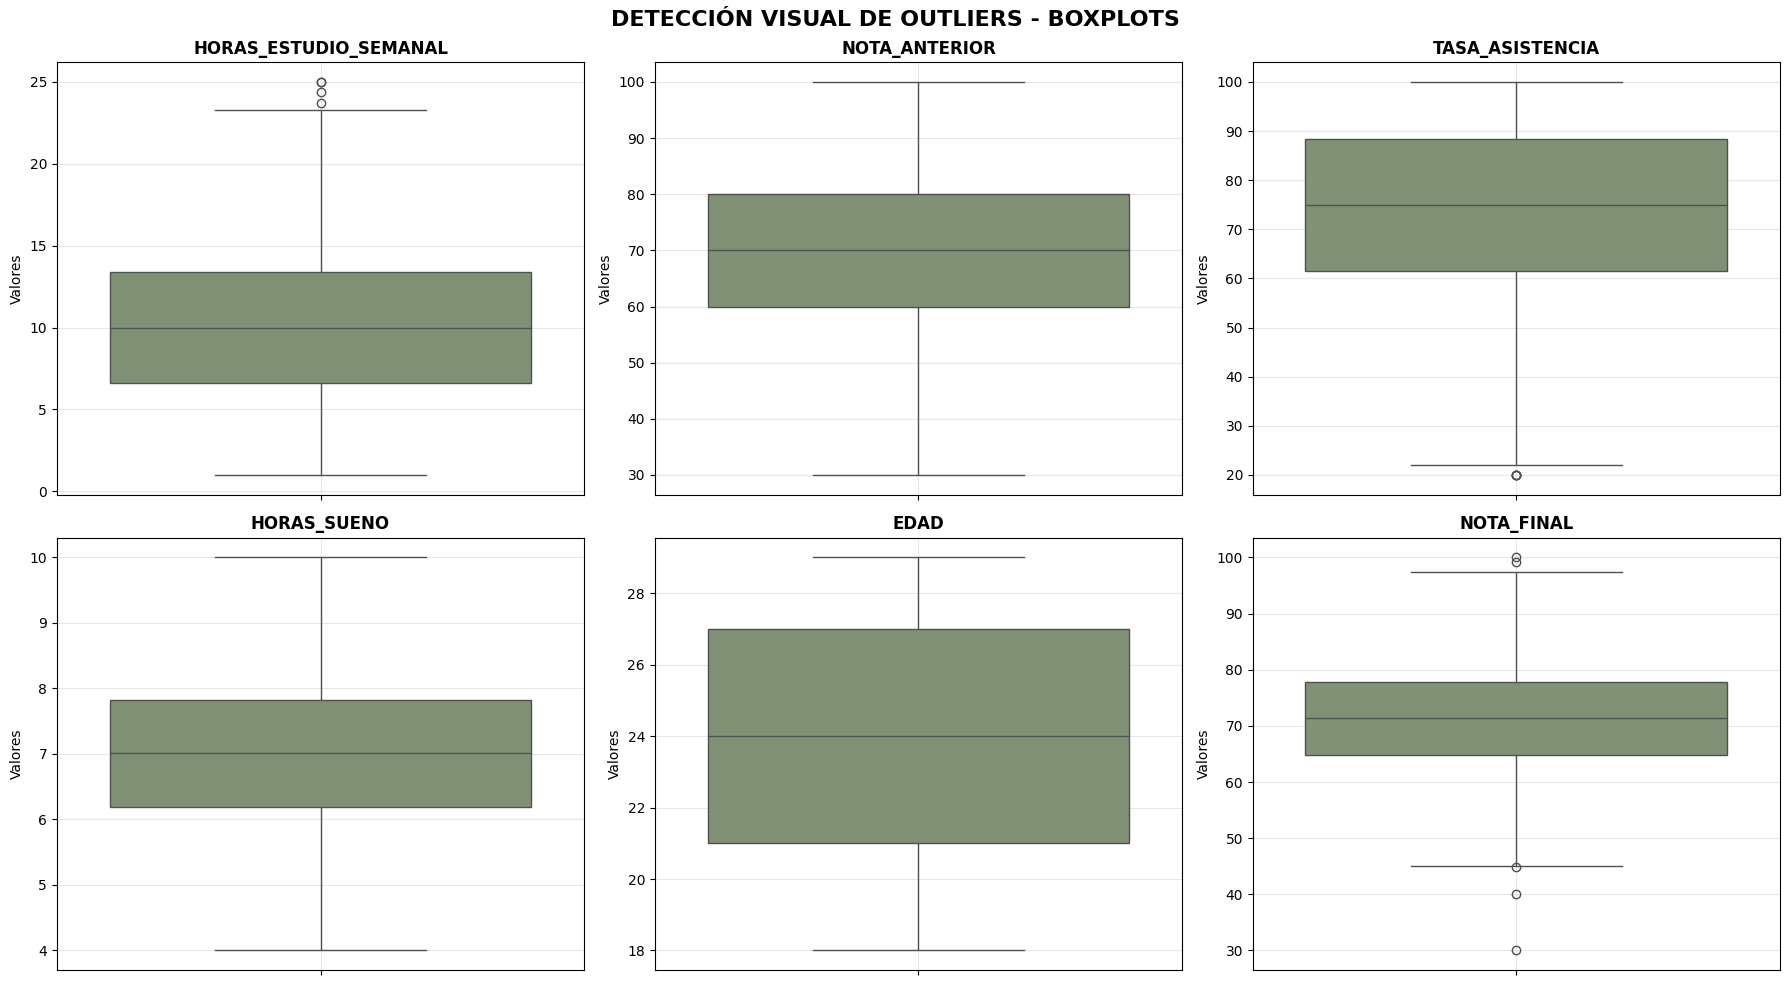

In [18]:
# Variables numéricas a analizar
numeric_cols = ['HORAS_ESTUDIO_SEMANAL', 'NOTA_ANTERIOR', 'TASA_ASISTENCIA', 
                'HORAS_SUENO', 'EDAD', 'NOTA_FINAL']
# Crear subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('DETECCIÓN VISUAL DE OUTLIERS - BOXPLOTS', fontsize=16, fontweight='bold')
for idx, col in enumerate(numeric_cols):
    row = idx // 3
    col_idx = idx % 3
    
    sns.boxplot(
        y=df[col], 
        ax=axes[row, col_idx], 
        color='#809671'  # Color verde oliva
    )
    axes[row, col_idx].set_title(f'{col}', fontweight='bold', fontsize=12)
    axes[row, col_idx].set_ylabel('Valores')
    axes[row, col_idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detección de outliers con método IQR

Utilizamos el método del **Rango Intercuartílico (IQR)** con umbral de **1.5 × IQR**:
- Límite inferior = Q1 - 1.5 × IQR
- Límite superior = Q3 + 1.5 × IQR

In [14]:
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

print("=" * 80)
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR")
print("=" * 80)

for col in numeric_cols:
    outliers, lower, upper = detectar_outliers_iqr(df, col)
    n_outliers = len(outliers)
    pct = (n_outliers / len(df)) * 100
    
    print(f"\n{col}:")
    print(f"  Rango válido: [{lower:.2f}, {upper:.2f}]")
    print(f"  Outliers detectados: {n_outliers} ({pct:.2f}%)")
    
    if n_outliers > 0:
        below = len(df[df[col] < lower])
        above = len(df[df[col] > upper])
        if below > 0:
            print(f"  - Por debajo del límite: {below}")
        if above > 0:
            print(f"  - Por encima del límite: {above}")

DETECCIÓN DE OUTLIERS - MÉTODO IQR

HORAS_ESTUDIO_SEMANAL:
  Rango válido: [-3.49, 23.49]
  Outliers detectados: 4 (0.40%)
  - Por encima del límite: 4

NOTA_ANTERIOR:
  Rango válido: [29.53, 110.47]
  Outliers detectados: 0 (0.00%)

TASA_ASISTENCIA:
  Rango válido: [21.04, 128.96]
  Outliers detectados: 4 (0.40%)
  - Por debajo del límite: 4

HORAS_SUENO:
  Rango válido: [3.74, 10.28]
  Outliers detectados: 0 (0.00%)

EDAD:
  Rango válido: [12.00, 36.00]
  Outliers detectados: 0 (0.00%)

NOTA_FINAL:
  Rango válido: [45.09, 97.59]
  Outliers detectados: 5 (0.50%)
  - Por debajo del límite: 3
  - Por encima del límite: 2


### Decisión: Mantener todos los outliers

**Conclusión:** Los 13 outliers detectados (1.3% del dataset) son **valores legítimos**:
- Representan casos extremos reales (estudiantes con mucho/poco estudio, asistencia baja, notas muy altas/bajas)
- Son informativos para los modelos de Machine Learning
- Eliminarlos reduciría la capacidad del modelo para predecir casos extremos

## 4. Codificación de variables categóricas (encoding)

### Plan de acción
Según el EDA, tenemos 4 variables categóricas que requieren encoding. La estrategia dependerá de si existe un orden natural en las categorías:

- **NIVEL_DIFICULTAD** (3 categorías: Fácil, Medio, Difícil):
  - Estrategia: **Ordinal Encoding** (Fácil=0, Medio=1, Difícil=2)
  - Justificación: Existe un orden lógico y el EDA muestra diferencias graduales en el rendimiento según el nivel
  
- **TIENE_TUTOR** (2 categorías: Sí, No):
  - Estrategia: **Binary Encoding** (Sí=1, No=0)
  - Justificación: Variable binaria simple
  
- **HORARIO_ESTUDIO_PREFERIDO** (3 categorías: Mañana, Tarde, Noche):
  - Estrategia: **One-Hot Encoding** (3 columnas binarias)
  - Justificación: No hay un orden natural claro entre los horarios
  
- **ESTILO_APRENDIZAJE** (4 categorías: Visual, Auditivo, Lectura/Escritura, Kinestésico):
  - Estrategia: **One-Hot Encoding** (4 columnas binarias)
  - Justificación: No hay un orden natural entre los estilos

**Implementación**: 
- Usar `OrdinalEncoder` de scikit-learn para NIVEL_DIFICULTAD
- Usar `LabelEncoder` o mapeo manual para TIENE_TUTOR
- Usar `OneHotEncoder` o `pd.get_dummies()` para HORARIO_ESTUDIO_PREFERIDO y ESTILO_APRENDIZAJE

## 5. Estandarización de las variables numéricas

### Plan de acción
La necesidad de escalado/normalización depende del tipo de modelo que se vaya a utilizar:

**Modelos que REQUIEREN escalado:**
- Modelos basados en distancias: KNN, SVM
- Redes neuronales
- Modelos con regularización: Ridge, Lasso, Elastic Net
- Análisis de componentes principales (PCA)

**Modelos que NO requieren escalado:**
- Árboles de decisión
- Random Forest
- Gradient Boosting (XGBoost, LightGBM, CatBoost)
- Naive Bayes

**Métodos de escalado recomendados:**
- **StandardScaler** (media=0, std=1): Para distribuciones relativamente normales. Apropiado para la mayoría de nuestras variables numéricas según el EDA
- **MinMaxScaler** (rango 0-1): Si queremos mantener la interpretabilidad y el rango original
- **RobustScaler**: Si hay presencia de outliers (usa mediana e IQR en lugar de media y desviación estándar)

**Implementación**: 
- Crear pipelines que permitan activar/desactivar el escalado según el modelo
- Aplicar el escalado SOLO después de dividir train/test para evitar data leakage
- Guardar los parámetros del scaler del conjunto de entrenamiento para aplicar la misma transformación al test

## 6. Selección de variables (feature selection)

### Plan de acción
Según el EDA, se identificaron variables con baja o nula correlación con las variables objetivo:

**Variables a considerar eliminar:**
- **EDAD**: 
  - Correlación prácticamente nula (-0.01) con NOTA_FINAL
  - Sin diferencias significativas entre aprobados y suspendidos (ambos con mediana de 24 años)
  - Recomendación: Mantener inicialmente para validación, eliminar si no mejora el modelo
  
- **HORAS_SUENO**: 
  - Correlación muy débil (0.07) con NOTA_FINAL
  - Sin diferencias significativas entre aprobados (mediana: 7.01) y suspendidos (mediana: 7.05)
  - Además tiene 15% de valores faltantes
  - Recomendación: Mantener inicialmente para validación, eliminar si no mejora el modelo

**Variables a mantener** (alta predictividad):
- **HORAS_ESTUDIO_SEMANAL**: Correlación 0.51 con NOTA_FINAL, diferencia de 5.17 horas entre aprobados/suspendidos
- **NOTA_ANTERIOR**: Correlación 0.47 con NOTA_FINAL, diferencia de 12.49 puntos entre aprobados/suspendidos
- **TASA_ASISTENCIA**: Correlación 0.32 con NOTA_FINAL, diferencia de 14.44 puntos porcentuales
- **TIENE_TUTOR**: Diferencia de 10 puntos porcentuales en tasa de aprobado
- **Todas las variables categóricas**: Muestran impacto en los objetivos según el EDA

**Feature Engineering - Interacciones sugeridas:**
- `HORAS_ESTUDIO_SEMANAL × TIENE_TUTOR`: ¿El tutor multiplica el efecto de las horas de estudio?
- `NOTA_ANTERIOR × NIVEL_DIFICULTAD`: ¿La dificultad percibida modera el efecto de la nota anterior?
- `TASA_ASISTENCIA × HORAS_ESTUDIO_SEMANAL`: Efecto sinérgico de asistencia y estudio

**Implementación**: 
- Probar modelos con y sin EDAD y HORAS_SUENO para comparar rendimiento
- Crear features de interacción para las combinaciones sugeridas
- Usar técnicas de selección de features (SelectKBest, Recursive Feature Elimination) si el número de features crece significativamente

## 7. Preparación específica para REGRESIÓN (NOTA_FINAL)

### Plan de acción
Para el modelo de regresión que predice NOTA_FINAL:

**Preparación de la variable objetivo:**
- **NOTA_FINAL**: Variable continua (rango 30-100)
- El EDA muestra distribución relativamente normal (media: 71.44, mediana: 71.4, std: 9.56)
- Probablemente no necesite transformación, pero validar distribución de residuos según modelo elegido

**División Train/Test/Validation:**
- División recomendada: 70% train, 15% validation, 15% test
- Estratificar NO es necesario (variable continua)
- Asegurar que la distribución de NOTA_FINAL sea similar en todos los sets (verificar estadísticas descriptivas)

**Consideraciones adicionales:**
- No se requiere balanceo de clases (es regresión)
- Validar supuestos del modelo según el algoritmo elegido (normalidad de residuos, homocedasticidad, etc.)


## 8. Preparación específica para CLASIFICACIÓN (APROBADO)

### Plan de acción
Para el modelo de clasificación que predice APROBADO:

**Balanceo de Clases (CRÍTICO):**
- **Problema detectado**: Desbalance severo (89.8% aprobados vs 10.2% suspendidos)
- Este es el paso MÁS IMPORTANTE para clasificación, ya que sin balanceo el modelo tendrá sesgo hacia la clase mayoritaria

**Estrategias a probar y comparar:**
1. **SMOTE** (Synthetic Minority Oversampling Technique):
   - Generar muestras sintéticas de la clase minoritaria (suspendidos)
   - Ventaja: Aumenta la clase minoritaria sin perder información
   - Implementación: `imbalanced-learn` library (`SMOTE()`)

2. **Ajuste de pesos en el modelo**:
   - Usar `class_weight='balanced'` en modelos de scikit-learn
   - Ajustar manualmente pesos según ratio: {0: 8.98, 1: 1.02} (aproximado)
   - Ventaja: No modifica los datos, solo ajusta la función de costo

3. **Combinación SMOTE + Tomek Links**:
   - SMOTE para oversampling + Tomek Links para limpieza de muestras
   - Puede mejorar la calidad de las muestras sintéticas

4. **Undersampling** (menos recomendado):
   - Reducir la clase mayoritaria
   - Riesgo: Pérdida de información valiosa
   - Solo considerar si el dataset es muy grande

**Métricas de evaluación apropiadas:**
- ❌ NO usar **Accuracy** (será engañoso, siempre predecirá "Aprobado")
- ✅ Usar: **Precision**, **Recall**, **F1-score**, **ROC-AUC**, **Matriz de confusión**
- Priorizar **Recall de la clase minoritaria** (suspendidos) si es crítico detectarlos

**División Train/Test/Validation:**
- División recomendada: 70% train, 15% validation, 15% test
- **IMPORTANTE**: Estratificar por APROBADO para mantener proporciones en todos los sets
- **CRÍTICO**: Aplicar balanceo SOLO en el conjunto de entrenamiento, NO en validation/test

**Preparación de la variable objetivo:**
- **APROBADO**: Variable binaria (0=Suspenso, 1=Aprobado)
- Verificar que esté como tipo int o bool
- Ya está en formato correcto según el EDA
